# Homework Week 04
Nicola Zomer <br>
10 November, 2022

## Assignment
1) Generate a random a SxS matrix with C non zero entries and 1-C zeros (C is between zero and one). Set the diagonal to -d. The non-zero elements are drawn  from a given distributions. Calculate the eigenvalues. Repeat different realizations and plot all the eigenvalues in the complex plane [Real part (x-axis) and imaginary part (y-axis)]. Compare this result with the expectations from the circular law. 
   
2) Generate the same as above but for mutualistic structure and find how the maximum real eigenvalues scales with S (use S=20,30,40,..100) and compare your numerical finding with the analytical expectations (we did not explicitly have calculated this in class). 
   
3) Analyse the food web using the metrics we have seen in class. The file represent the weighted adjacency matrix of the food web. For the analysis you can binarize (zero and one) the matrix. You find the file in the google drive.
   
4) (optional) Calculate the same as 1) but with for the cascade model or for the nested mutualistic network. 

In [10]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
import pandas as pd

# dash
from jupyter_dash import JupyterDash
from dash import Dash
## from dash import dcc
## from dash import html
from dash.dependencies import Output, State, Input

# plotly
import plotly.express as px

%matplotlib inline

# show static images for github
from IPython.display import Image, display
savegit = True

# Point 1 
## The Circular Law
Consider the Generalized Lotka-Volterra Dynamics, describing the interaction of $S$ species through a network:
$$
    \frac{dN_i}{dt} = a_iN_i(t)- N_i(t)\sum_{j=1}^{S} \alpha_{ij}N_j(t) \quad i=1, ..., S
$$
The Jacobian matrix evaluated at the non-trivial equilibrium point of the system is given by:
$$
    J_{ij}=\frac{\partial \dot{N}_i}{\partial N_j}\Bigr\rvert_{\bar{N}^*} = N_i^*\alpha_{ij}
$$

We consider a stationary point $\bar{N}^*=(1, 1, ...., 1)$, which implies that $J_{ij}=\alpha_{ij}$, and we model $\alpha$ as a random matrix, for example assuming that $\alpha_{ij}$ are drawn from a Gaussian distribution, $\alpha_{ij} \sim \mathcal{N}(0, \sigma^2)$. Assuming interactions are i.i.d. random variables and $\alpha_{ii}=0$ for all $i=1, ..., S$, then all eigenvalues of $\alpha/\sqrt{S\sigma^2}$ are uniformly distributed within the unitary disk in the complex plane. This is called _Circular Law_.

Moreover, if we add the effect of self-interactions and we model it as a constant intra-specied competition, $\alpha_{ii}=-d <0$, then the disk containing all the eigenvalues of $\alpha$ is translated on the real axis, that is:
- the disk center is $(-d, 0)$
- the disk radius is $\sqrt{S\sigma^2}$

Notice that in general $\sigma$ is the standard deviation of the random variable $X$ from which the coefficients $\alpha_{ij}$ take value. 

If we further introduce a constant $C$, called _connectance_, such that with probability $C$ the coefficient of $\alpha_{ij}$ are sampled by the selected distribution and with probability $0$ are set to $0$, than the radius of the disk becomes:
$$
    r= \sqrt{SC\sigma^2}
$$


## Construction of the Random Matrices
Notation: in this context we call $M_{ij}$ the random matrix, and $\mathcal{D}$ the distribution we have selected (for example $\mathcal{D} =\mathcal{N}(0, \sigma^2)$). 

**Off-diagonal elements** <br>
For each off-diagonal term of the matrix we draw a random value $p$ from a uniform distribution $\mathcal{U}[0, 1]$. If $p<C$, we set $M_{ij}$ by sampling it from $\mathcal{D}$, otherwise we impose $M_{ij}=0$

**Diagonal elements** <br>
All diagonal elements, $M_{ii}$, are set to $−d$. 



In [2]:
# random matrix generation
def randommatrix(size, diag, connectance, D=lambda: np.random.normal(0, sigma), mutualistic=False):
    '''
    INPUT:
    - size        -> size of the square matrix (i.e. number of species) 
    - diag        -> value of d (>0)
    - connectance -> value of C (0<C<1)
    - D           -> the selected distribution, by default a gaussian distribution
    - mutualistic -> if True, consider only mutualistic interactions
    
    OUTPUT:
    - M -> the random matrix
    
    '''
    
    assert diag>0, 'diag  must be >0'
    assert 0<connectance<1, 'connectance must be between 0 and 1'
    
    # initialize matrix
    M = np.zeros((size, size))
    
    # 1. off-diagonal elements
    for i in range(size):
        for j in range(size):
            if i!=j:
                p = np.random.uniform()
                
                if p<connectance:
                    if not mutualistic:
                        M[i, j] = D()
                    else:
                        M[i, j] = np.abs(D())
    
    # 2. diagonal elements
    np.fill_diagonal(M, -diag)

    return M


# circle extremes
def my_circle(center, radius):
    '''
    INPUT:
    - center -> [ , ], center of the disk
    - radius -> float, radius of the disk
    
    OUTPUT: 
    - x0 -> min(x)
    - y0 -> min(y)
    - x1 -> max(x)
    - y1 -> max(y)
    
    '''
    
    x0_ = center[0]-radius
    y0_ = center[1]-radius
    x1_ = center[0]+radius
    y1_ = center[1]+radius

    return x0_, y0_, x1_, y1_


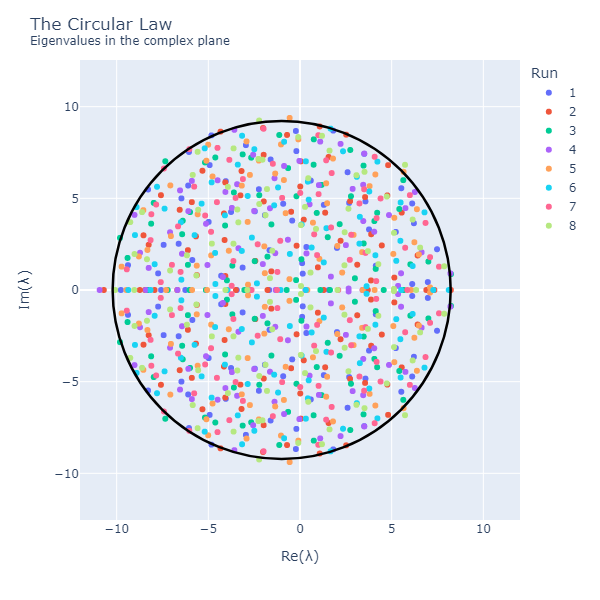

In [13]:
np.random.seed(1245)

# parameters
C = 0.85
d = 1
S = 100
sigma = 1

# center and radius of the circle
center = [-d, 0]
radius = m.sqrt(S*C*sigma**2)

# build N random matrices
N = 8
appended_data = []

for i in range(N):
    df_eig = pd.DataFrame(columns=['re', 'im', 'run'])
    
    M = randommatrix(S, d, C)
    eig_M, _ = np.linalg.eig(M)
    df_eig['re'] = np.real(eig_M)
    df_eig['im'] = np.imag(eig_M)
    df_eig['run'] = [str(i+1)]*len(eig_M)
    
    appended_data.append(df_eig)
    
appended_data = pd.concat(appended_data)

# circle data
x0, y0, x1, y1 = my_circle(center, radius)

# plot the eigenvalues
fig = px.scatter(appended_data, x="re", y="im", color="run")

fig.update_layout(
    title="The Circular Law <br><sup>Eigenvalues in the complex plane</sup>",
    xaxis_title="Re(λ)",
    yaxis_title="Im(λ)",
    legend_title="Run",
    width=600,
    height=600,
)
fig.update_xaxes(range=[-12, 12])
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
    range=[-12, 12]
  )

fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=x0, y0=y0, x1=x1, y1=y1,
    line_color="black",
    line_width = 2.5
)
# fig.add_annotation(
#     x= center[0]+radius,
#     y= center[1],
#     xref="x", yref="y",
#     text="",
#     showarrow=True,
#     axref = "x", ayref='y',
#     ax= center[0],
#     ay= center[1],
#     arrowhead = 3,
#     arrowwidth= 2, 
#     arrowcolor='black')

if savegit: 
    path = "images/hw04_circlaw.png"
    fig.write_image(path)
    display(Image(path))
    
else:
    fig.show()

# Point 2
To  generate the same as above for mutualistic structure simply impose that with probability $C$:
$$
    \{\alpha_{ij}, \alpha{ji}\} = \{|x_1|, |x_2|\}
$$ 
where $x_1$ and $x_2$ are sampled from the distribution $\mathcal{D}$.



,Maxeig,S
0,12.36,20
1,18.21,30
2,25.52,40
3,32.69,50
4,38.55,60
5,45.82,70
6,52.63,80
7,59.69,90
8,65.90,100


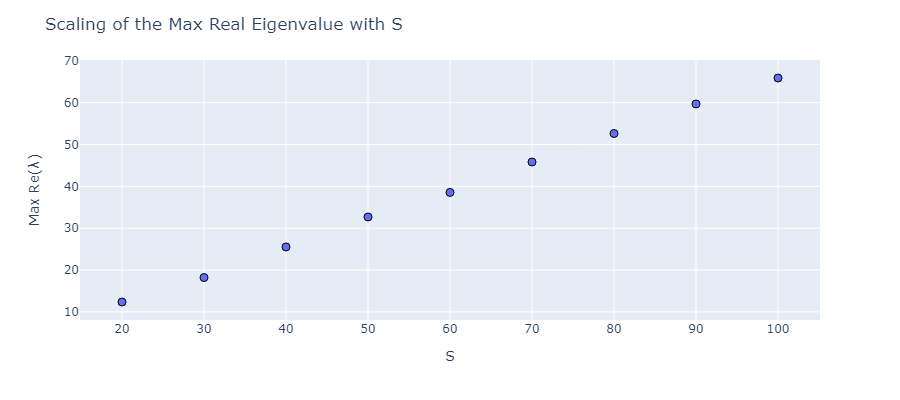

In [12]:
np.random.seed(1245)

# setting
S_vec = np.arange(20, 110, 10).astype(int)  # number of species
N = 5                                       # number of iterations for each species (take the average value)

df_max_re = pd.DataFrame(columns=['Maxeig', 'S'])
appended_data = []

# build the random matrices and find the max real eigenvalue
for s in S_vec:
    max_eig = []
    for i in range(N):
        M = randommatrix(s, d, C, mutualistic=True)
        eig_M, _ = np.linalg.eig(M)
        
        max_eig.append(np.max(np.real(eig_M)))
    
    df_max_re = df_max_re.append({'Maxeig': np.average(max_eig), 'S':str(s)}, ignore_index=True)
        
display(df_max_re.round(2))

# plot
fig = px.scatter(df_max_re, x="S", y="Maxeig")

fig.update_layout(
    title="Scaling of the Max Real Eigenvalue with S",
    xaxis_title="S",
    yaxis_title="Max Re(λ)",
    width=900,
    height=400
)
fig.update_traces(
    marker = dict(size=8,
                  line=dict(width=1, color='Black')
    )
)

if savegit: 
    path = "images/hw04_scaling_maxeig.png"
    fig.write_image(path)
    display(Image(path))
    
else:
    fig.show()


## Additional 1: other structures
- Predator - Prey Structure
- Competitive + Mutualistic Structure

In [14]:
# random matrix generation, competitive + mutualistic or predator-prey
def randommatrix_cm_pp(size, diag, connectance, D=lambda: np.random.normal(0, sigma), competitivemutualistic=True):
    '''
    INPUT:
    - size                   -> size of the square matrix (i.e. number of species) 
    - diag                   -> value of d (>0)
    - connectance            -> value of C (0<C<1)
    - D                      -> the selected distribution, by default a gaussian distribution
    - competitivemutualistic -> if true, competitive + mutualistic, else predator-prey interaction
    
    OUTPUT:
    - M -> the random matrix
    
    '''
    
    assert diag>0, 'diag  must be >0'
    assert 0<connectance<1, 'connectance must be between 0 and 1'
    
    # initialize matrix
    M = np.zeros((size, size))
    
    # 1. off-diagonal elements
    for i in range(size):
        for j in range(i+1, size):
            p = np.random.uniform()
                
            if p<connectance/2:
                if competitivemutualistic: 
                    # mutualistic pair of species
                    M[i, j] = np.abs(D())
                    M[j, i] = np.abs(D())
                else:
                    # predator-prey interaction (ij>0, ji<0)
                    M[i, j] = np.abs(D())
                    M[j, i] = -np.abs(D())
                
            elif connectance/2<p<connectance:
                if competitivemutualistic:
                    # competitive pair of species
                    M[i, j] = -np.abs(D())
                    M[j, i] = -np.abs(D())
                else:
                    # predator-prey interaction (ij<0, ji>0)
                    M[i, j] = -np.abs(D())
                    M[j, i] = np.abs(D())
    
    # 2. diagonal elements
    np.fill_diagonal(M, -diag)

    return M


# rho
def correlation(M):
    '''
    INPUT: matrix M
    OUTPUT: expected correlation rho between Mij and Mji
    
    '''
    
    E_aij = M.mean()
    E_aij_aji = np.mean((M*M.T)[np.triu_indices(M.shape[0])])
    Var_aij = M.var()
    
    return (E_aij_aji - E_aij**2)/Var_aij


# rho knowing the distribution
def correlation_zeromean(M, connectance, sigma):
    '''
    INPUT: matrix M, connectance, standard deviation sigma
    OUTPUT: expected correlation rho between Mij and Mji
    
    '''
    E_aij_aji = np.mean((M*M.T)[np.triu_indices(M.shape[0])])
    
    return (E_aij_aji)/(connectance*sigma**2)


# ellipse extremes
def my_ellipse(center, radius, rho):
    '''
    INPUT:
    - center -> [ , ], center of the disk
    - radius -> float, radius of the disk
    - rho    -> correlation coefficient
    
    OUTPUT: 
    - x0 -> min(x)
    - y0 -> min(y)
    - x1 -> max(x)
    - y1 -> max(y)
    
    '''
    
    a = radius*(1+rho)
    b = radius*(1-rho)
    
    x0_ = center[0]-a
    y0_ = center[1]-b
    x1_ = center[0]+a
    y1_ = center[1]+b

    return x0_, y0_, x1_, y1_

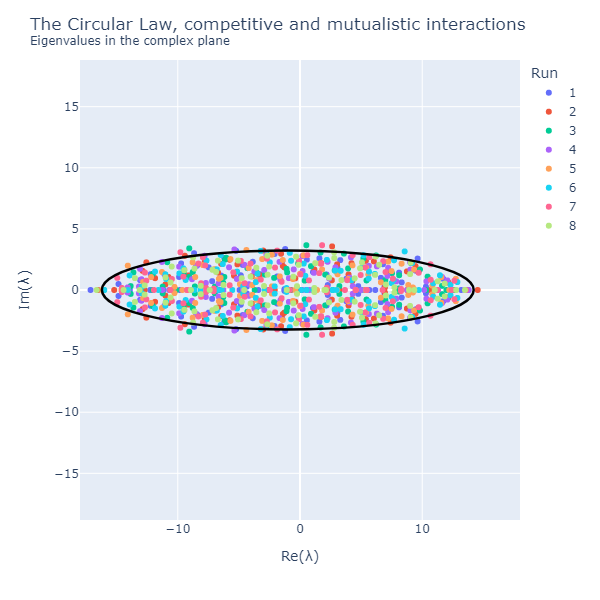

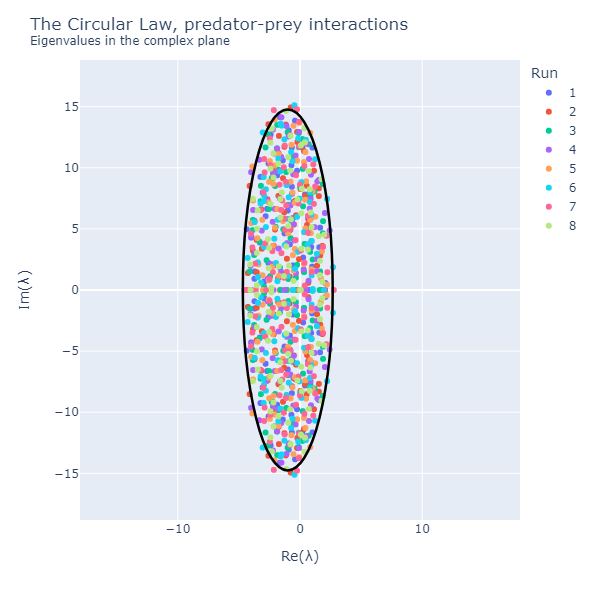

In [15]:
np.random.seed(1245)

# parameters
C = 0.85
d = 1
S = 100
sigma = 1

# center and radius of the circle
center = [-d, 0]
radius = m.sqrt(S*C*sigma**2)

# initialize lists
N = 8
appended_data_cm = []
appended_data_pp = []

# build N random matrices with competitive + mutualistic structure
rho_values = []

for i in range(N):
    df_eig = pd.DataFrame(columns=['re', 'im', 'run'])
    
    M = randommatrix_cm_pp(S, d, C, competitivemutualistic=True)
    eig_M, _ = np.linalg.eig(M)
    df_eig['re'] = np.real(eig_M)
    df_eig['im'] = np.imag(eig_M)
    df_eig['run'] = [str(i+1)]*len(eig_M)
    
    appended_data_cm.append(df_eig)
    rho_values.append(correlation_zeromean(M, C, sigma))
    
appended_data_cm = pd.concat(appended_data_cm)
rho_cm = np.mean(rho_values)

# build N random matrices with predator-prey structure
rho_values = []

for i in range(N):
    df_eig = pd.DataFrame(columns=['re', 'im', 'run'])
    
    M = randommatrix_cm_pp(S, d, C, competitivemutualistic=False)
    eig_M, _ = np.linalg.eig(M)
    df_eig['re'] = np.real(eig_M)
    df_eig['im'] = np.imag(eig_M)
    df_eig['run'] = [str(i+1)]*len(eig_M)
    
    appended_data_pp.append(df_eig)
    rho_values.append(correlation_zeromean(M, C, sigma))
    
appended_data_pp = pd.concat(appended_data_pp)
rho_pp = np.mean(rho_values)

# ellipses data
x0_cm, y0_cm, x1_cm, y1_cm = my_ellipse(center, radius, rho_cm)
x0_pp, y0_pp, x1_pp, y1_pp = my_ellipse(center, radius, rho_pp)

# plot cm eigenvalues
fig = px.scatter(appended_data_cm, x="re", y="im", color="run")

fig.update_layout(
    title="The Circular Law, competitive and mutualistic interactions<br><sup>Eigenvalues in the complex plane</sup>",
    xaxis_title="Re(λ)",
    yaxis_title="Im(λ)",
    legend_title="Run",
    width=600,
    height=600,
)
fig.update_xaxes(range=[-18, 18])
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
    range=[-18, 18]
  )

fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=x0_cm, y0=y0_cm, x1=x1_cm, y1=y1_cm,
    line_color="black",
    line_width = 2.5
)

if savegit: 
    path = "images/hw04_compmutual.png"
    fig.write_image(path)
    display(Image(path))
    
else:
    fig.show()

# plot pp eigenvalues
fig = px.scatter(appended_data_pp, x="re", y="im", color="run")

fig.update_layout(
    title="The Circular Law, predator-prey interactions<br><sup>Eigenvalues in the complex plane</sup>",
    xaxis_title="Re(λ)",
    yaxis_title="Im(λ)",
    legend_title="Run",
    width=600,
    height=600,
)
fig.update_xaxes(range=[-18, 18])
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
    range=[-18, 18]
  )

fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=x0_pp, y0=y0_pp, x1=x1_pp, y1=y1_pp,
    line_color="black",
    line_width = 2.5
)

if savegit: 
    path = "images/hw04_predatorprey.png"
    fig.write_image(path)
    display(Image(path))
    
else:
    fig.show()
    

## Additional 2: Dashboard

Idee per la dashboard: 
- S fisso
- d, C imposti dall'utente, con dei vincoli (d>0, C<1)
- sigma imposto se seleziono non uniforme
- possibilità di selezionare tra diverse distribuzioni (uniforme, normale, exponential)

In [ ]:
pd.options.plotting.backend = "plotly"

app = JupyterDash(__name__)

app.layout = html.Div([
        dcc.Input(id='a', type='number', placeholder='a', style={'padding':3,'fontSize':18}),
        dcc.Input(id='c', type='number', placeholder='c', style={'padding':3,'fontSize':18}),
        dcc.Input(id='p', type='number', placeholder='p', style={'padding':3,'fontSize':18}),
        dcc.Input(id='x0', type='number', placeholder='x0', style={'padding':3,'fontSize':18}),
        dcc.Input(id='y0', type='number', placeholder='y0', style={'padding':3,'fontSize':18}),
        html.Button(id='submit-button', type='submit', children='Submit', style={'padding':10,'fontSize':18}),
        html.Div(id='output_div')], 
        
                      )

@app.callback(Output('output_div', 'children'),
             [Input('submit-button', 'n_clicks')],
             [State('a', 'value'), State('c', 'value'), State('p', 'value'), 
              State('x0', 'value'), State('y0', 'value')])
             
                                    
def update_output(clicks, a, c, p, x0, y0):
        if clicks is not None:
            s0 = [x0, y0]   # initial conditions
            solution = odeint(system, s0, t, args=(a, c, p))
            arr = np.array([t, solution[:,0], solution[:,1]]).T
            df = pd.DataFrame(arr, columns = ['t[s]', 'Prey', 'Predators'])
            fig = px.line(df , x='t[s]', title='Lotka-Volterra Model', y=['Prey', 'Predators'], 
              labels={'value':'Dynamics', 'variable':'Species', 't[s]':'t [s]'},
              markers=True, height=600, width=1200)
            fig.update_layout(font=dict(size=20))
            
            return dcc.Graph(figure=fig)



app.run_server(mode='inline')

# Point 3

# Point 4